In [4]:
import numpy as np
import matplotlib.pyplot as plt
import astropy
import fitsio

In [5]:
import astropy.units as u
from astropy.table import Table, vstack

In [6]:
from astropy.wcs import WCS

In [7]:
from astropy.coordinates import SkyCoord, search_around_sky

In [8]:
import sys
sys.path.append("../src/")
from plot_utils import plot_zscale_image, show_imstat
from crossmatch import find_sweep_with_ra_dec, convert_flux_to_mag

In [17]:
from pathlib import Path

wiro_dir = Path("/global/cfs/cdirs/desi/users/adamyers/wiro")
reduced_dir = wiro_dir / "reduced"
# astrometric_dir = Path("/global/cscratch1/sd/brookluo/astrometry")
astrometric_dir = wiro_dir / "solved-wcs"

imdata_1031 = reduced_dir / "20221031"
wcs_1031 = astrometric_dir / "20221031"
imdata_1028 = reduced_dir / "20221028"
wcs_1028 = astrometric_dir / "20221028"
imdata_1030 = reduced_dir / "20221030"
wcs_1030 = astrometric_dir / "20221030"

wcs_coadd = astrometric_dir  / "coadd-images"
imdata_coadd = reduced_dir / "coadd-images"

In [221]:
fn_coadd = "g-5-XMM-combined"
imwcs = WCS(str(wcs_coadd / f"{fn_coadd}.new"))

In [222]:
source = fitsio.read(wcs_coadd / (fn_coadd + ".axy"))

In [223]:
sources_coord = imwcs.pixel_to_world(source["X_IMAGE"], source["Y_IMAGE"])

In [224]:
radec_tab = sources_coord.to_table()
newtab = Table([radec_tab["ra"].value, radec_tab["dec"].value], names=["RA", "DEC"])

In [225]:
# matching with Gaia
# from desitarget import gaiamatch, geomask

# import os

# gaia_dir = "/global/cfs/cdirs/desi/target/gaia_dr3"
# os.environ["GAIA_DIR"] = gaia_dir

# matched_sources = gaiamatch.match_gaia_to_primary(newtab, matchrad=3, retaingaia=False, dr="dr3")

# pick_good = matched_sources["REF_ID"] > 0

# matched_sources.dtype

# matched_sources["GAIA_PHOT_G_MEAN_MAG"]

In [226]:
sweeps = set()
for coord in sources_coord:
    sweeps.add(find_sweep_with_ra_dec(coord.ra.to(u.deg).value, coord.dec.to(u.deg).value))
# sweeps = list(sweeps)

In [227]:
ls_ds9_dir = Path("/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/south/sweep/9.0")

In [228]:
tab = Table()
for file in sweeps:
    tab = vstack([tab, Table.read(ls_ds9_dir/file)])

In [229]:
sweep_radec = SkyCoord(ra=tab["RA"], dec=tab["DEC"])

In [269]:
pick_psf = tab["TYPE"] == "PSF"

In [270]:
idx_sweep, idx_sources, *others = sources_coord.search_around_sky(sweep_radec[pick_psf], seplimit=4*u.arcsec)

In [280]:
flux_ext_cor = tab[pick_psf][idx_sweep]["FLUX_G"] / tab[pick_psf][idx_sweep]["MW_TRANSMISSION_G"]
match_g_mag = convert_flux_to_mag(flux_ext_cor)
all_g_mag = convert_flux_to_mag(tab["FLUX_G"] / tab["MW_TRANSMISSION_G"])
print(max(match_g_mag))
idx_max_g_mag = np.argmax(match_g_mag)

/global/u1/b/brookluo/WIRO-observation/notebooks/../src/crossmatch.py:14: RuntimeWarning: invalid value encountered in log10
  m = 22.5 - 2.5 * np.log10(flux)
/global/u1/b/brookluo/WIRO-observation/notebooks/../src/crossmatch.py:14: RuntimeWarning: divide by zero encountered in log10
  m = 22.5 - 2.5 * np.log10(flux)


31.392761


In [281]:
upper_bound = 28
pick_mag = match_g_mag >= upper_bound

In [282]:
matched_tab_image_coord = imwcs.world_to_pixel(sweep_radec[idx_sweep[pick_mag]])

In [283]:
imdata = fitsio.read(imdata_coadd / (fn_coadd+".fits"))

In [284]:
# fig, ax = plt.subplots(1, 1, figsize=(12, 10))
# vmin, vmax = plot_zscale_image(imdata, ax, cmap="gray")
# ax.scatter(source["X_IMAGE"][idx_sources[pick_mag]],
#            source["Y_IMAGE"][idx_sources[pick_mag]], 
#            s=100,
#            facecolors='none', edgecolors='r', label="WIRO")
# ax.scatter(matched_tab_image_coord[0], matched_tab_image_coord[1], s=100,
#             facecolors='none', edgecolors='b', label="LS DS9")
# ax.scatter(source["X_IMAGE"][idx_sources[idx_max_g_mag]],
#            source["Y_IMAGE"][idx_sources[idx_max_g_mag]], 
#            s=150, marker='x', label="max G mag")
# plt.legend()
# plt.title(f"{fn_coadd}, max G mag: {max(g_mag):.3f}, G band mag > {upper_bound}, num of sources: {len(np.unique(idx_sweep[pick_mag])):d}")
# plt.savefig(f"depth_{fn_coadd}.pdf")

/global/homes/b/brookluo/.conda/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


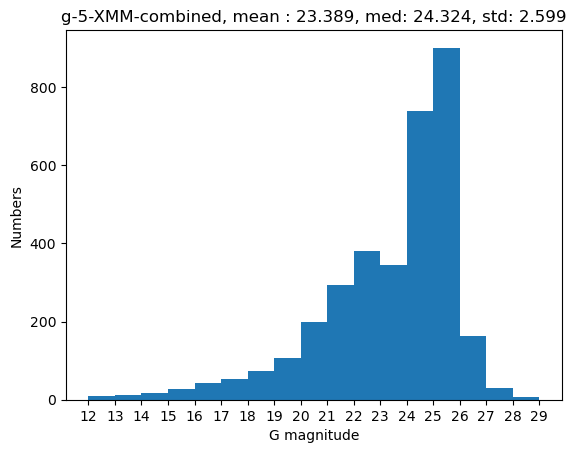

In [285]:
counts, bins, _ = plt.hist(match_g_mag, bins=np.arange(12, 30, 1))
plt.xlabel("G magnitude")
plt.ylabel("Numbers")
plt.xticks(np.arange(12, 30, 1))
plt.title(f"{fn_coadd}, mean : {np.mean(match_g_mag):.3f}, med: {np.median(match_g_mag):.3f}, std: {np.std(match_g_mag):.3f}")
plt.savefig(f"{fn_coadd}-match-LS-DS9.png")

In [286]:
pick_radec = sweep_radec.contained_by(imwcs)

In [287]:
counts, bins = np.histogram(match_g_mag, bins=np.arange(12, 30, 1))
all_counts, _ = np.histogram(all_g_mag[pick_radec & pick_psf], bins=bins)

In [288]:
counts / all_counts

array([0.5625    , 0.6875    , 0.62068966, 0.60869565, 0.63235294,
       0.65060241, 0.60330579, 0.63690476, 0.64401294, 0.64900662,
       0.41036717, 0.25054308, 0.08957576, 0.07583537, 0.09326425,
       0.08587258, 0.05454545])

/global/homes/b/brookluo/.conda/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


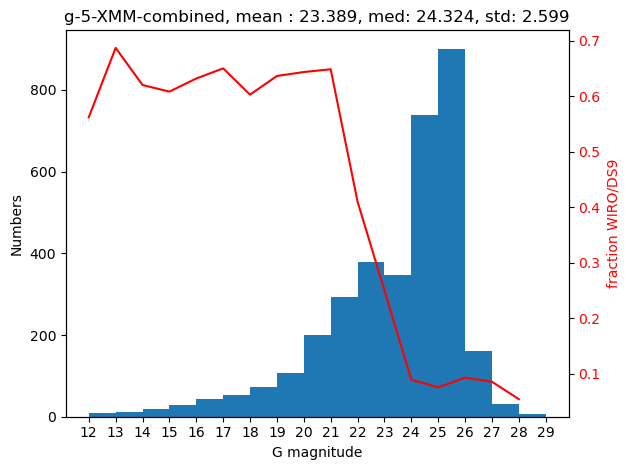

In [289]:
fig, ax1 = plt.subplots()
ax1.hist(match_g_mag, bins=bins)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('fraction WIRO/DS9', color='r')  # we already handled the x-label with ax1
ax2.plot(bins[:-1], counts / all_counts, color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax1.set_xlabel("G magnitude")
ax1.set_ylabel("Numbers")
plt.xticks(np.arange(12, 30, 1))
plt.title(f"{fn_coadd}, mean : {np.mean(match_g_mag):.3f}, med: {np.median(match_g_mag):.3f}, std: {np.std(match_g_mag):.3f}")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.show()
plt.savefig(f"psf_fraction_{fn_coadd}-match-LS-DS9.png")

In [295]:
source

array([(2126.5513, 2614.7144  , -22.942858 , 1.5036380e+09),
       ( 372.9722, 1800.6254  , -21.809547 , 5.2944282e+08),
       (2809.7312,   62.077877, -20.938578 , 2.3737269e+08), ...,
       (1365.6005, 3840.1533  ,  -7.4078608, 9.1863770e+02),
       (1189.8007, 2975.374   ,  -7.376805 , 8.9273389e+02),
       ( 783.0001, 2959.51    ,  -7.365154 , 8.8320508e+02)],
      dtype=[('X_IMAGE', '>f4'), ('Y_IMAGE', '>f4'), ('MAG_AUTO', '>f4'), ('FLUX_AUTO', '>f4')])

In [296]:
sources_coord

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(34.62222016, -4.86959729), (34.90270517, -4.99936582),
     (34.51259343, -5.27674898), ..., (34.74368245, -4.67459312),
     (34.77192986, -4.81219807), (34.83694122, -4.81474302)]>

In [320]:
from astropy.table import join, hstack

In [324]:
gtab = Table([sources_coord.ra, sources_coord.dec], names=["RA", "DEC"])
gtab = hstack([gtab, Table(source)])

In [326]:
gtab.write(wcs_coadd / "g-5-XMM-combined-sources.fits")

In [327]:
Table.read(wcs_coadd / "g-5-XMM-combined-sources.fits")

RA,DEC,X_IMAGE,Y_IMAGE,MAG_AUTO,FLUX_AUTO
deg,deg,,,,
float64,float64,float32,float32,float32,float32
34.62222015507523,-4.86959728504458,2126.5513,2614.7144,-22.942858,1503638000.0
34.90270517273842,-4.999365822721793,372.9722,1800.6254,-21.809547,529442800.0
34.51259343425153,-5.276748977639419,2809.7312,62.077877,-20.938578,237372690.0
34.6375007720575,-4.600405023826925,2029.9025,4306.5864,-20.771832,203578700.0
34.852832814787824,-5.147863244247015,685.40765,869.4239,-20.042082,103951976.0
34.94992958599756,-4.73421154793779,74.860596,3465.844,-19.77736,81460050.0
34.48696220430957,-5.132449015839215,2970.9934,965.92816,-19.19563,47670684.0
34.405934541680736,-4.872436702751545,3478.952,2596.8745,-19.005768,40022784.0
